# <b>Notebook-3: Electricity Price Prediction - Window Size 15</b>
by Qianjing Liang (8434350), Daniel Barbie (4939697), Jacob Umland (8436406),  Fan Jia (8436217), Jan Faulstich (8439328)

# Preparations
<b>Firstly, we downloaded the data, imported necessary packages and loaded the data into DataFrames. We have also created a dataframe for summarizing the models' performance. </b>

In [1]:
pip install tensorflow-addons

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Electricity_Data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Electricity_Data


In [3]:
#Imports basic packages for our tasks
import pandas as pd
import numpy as np
import pickle

#Imports visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

#Import ML packages
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, cross_val_score
import lightgbm as lgb

#Import DL packages
import tensorflow as tf
import tensorflow.keras as k 
from keras.models import *
from keras.layers import merge
from keras.layers.core import *
from tensorflow.keras import Model, Sequential
from tensorflow.keras import backend as be
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, MaxPool1D, Embedding, Attention
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adadelta, Adam, RMSprop
from tensorflow.keras.regularizers import *
from tensorflow.math import exp
import tensorflow_addons as tfa

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [4]:
#Load the datasets with a sliding window size of 15
X_train_window_size_15 = pd.read_csv('X_train_window_size_15.csv')
X_valid_window_size_15 = pd.read_csv('X_valid_window_size_15.csv')
X_test_window_size_15 = pd.read_csv('X_test_window_size_15.csv')
X_train_window_size_15_tree = pd.read_csv('X_train_window_size_15_tree.csv')
X_valid_window_size_15_tree = pd.read_csv('X_valid_window_size_15_tree.csv')
X_test_window_size_15_tree = pd.read_csv('X_test_window_size_15_tree.csv')
y_train_window_size_15 = pd.read_csv('y_train_window_size_15.csv')
y_valid_window_size_15 = pd.read_csv('y_valid_window_size_15.csv')
y_test_window_size_15 = pd.read_csv('y_test_window_size_15.csv')

In [5]:
y_train_window_size_15 = y_train_window_size_15['y']
y_valid_window_size_15 = y_valid_window_size_15['y']
y_test_window_size_15 = y_test_window_size_15['y']

In [6]:
# Prepare a dataframe to store the performance of all models
performance_df = pd.DataFrame(columns=['Model', 'MAE score (on test set)', 'MSE score (on test set)'])

# Conventional ML models
<b>In the second part, conventional ML models are used to make predictions, serving as a baseline to be compared with DL approaches. </b>


### Evaluation Functions: MAE

In [7]:
def evaluate_model(model, X_test, y_test_true):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test_true, predictions)
    mse = mean_squared_error(y_test_true, predictions)
    print("Mean absolut error on test:", mae)
    print("Mean squared error on test:", mse)
    return mae, mse

In [8]:
def evaluate_3Dmodel(model, X_test, y_test_true):
    predictions = model.predict(X_test)
    predictions = predictions[:, -1]
    mae = mean_absolute_error(y_test_true, predictions)
    mse = mean_squared_error(y_test_true, predictions)
    print("Mean absolut error on test:", mae)
    return mae, mse

## Dummy regressor
Takeaways:

In [9]:
# Modeling
dummy_model = DummyRegressor()
dummy_model.fit(X_train_window_size_15, y_train_window_size_15)

# Evaluate model performance and store it
mae, mse = evaluate_model(dummy_model, X_test_window_size_15, y_test_window_size_15)
performance_df = performance_df.append({'Model': 'Dummy Regressor', 
                                        'MAE score (on test set)': round(mae, 4),
                                        'MSE score (on test set)': round(mse, 4)},
                                       ignore_index=True)

Mean absolut error on test: 3.01123314148565
Mean squared error on test: 41.92988765321217


## Linear Regression
As expected, the linear models performed poorly for our data, as indicated by the R2 scores for both degree 1 and degree 2 models. The near 0 R2 scores for both validation and testing suggest that dependent variable cannot be explained by our data. Even though in the plots, the predicted y basically covered the actual y, the non-linear nature of our data cannot be captured by linear models. Due to the computational limitation, we only include the degree 2 polynomial regression, which has already served our purpose. 

### Helper functions

In [10]:
# Modify the helper functions specifically for the linear models
# Function to perform Cross Validation on Linear Models
def get_cv_scores(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print('CV Mean of R2: ', np.mean(scores))
    print('CV STD of R2: ', np.std(scores))

# Function to evaluate Linear Models with plots
def evaluate_valid(model, X_valid, y_valid, X_test, y_test):
    predictions_valid = model.predict(X_valid)
    mae_valid = mean_absolute_error(y_valid, predictions_valid)
    r2_valid = r2_score(y_valid, predictions_valid)
    print("Validation MAE:", mae_valid)
    print("Validation R2:", r2_valid)

    predictions_test = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, predictions_test)
    mse_test = mean_squared_error(y_test, predictions_test)
    r2_test = r2_score(y_test, predictions_test)
    print("Test MAE:", mae_test)
    print("Test R2:", r2_test)
    
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(y_valid, predictions_valid, color='r', label='valid set', alpha=0.2)
    ax.scatter(y_test, predictions_test, color='b', label='test set', alpha=0.2)
    ax.set_title('Distributions of predicted and real Y')
    ax.set_xlabel('Actual Y')
    ax.set_ylabel('Predicted Y')
    ax.legend()

    return mae_test, mse_test

CV Mean of R2:  -0.04501339090207068
CV STD of R2:  0.028563834037815462
Validation MAE: 3.557461004974547
Validation R2: -0.050174386490726475
Test MAE: 3.1070344651482813
Test R2: -0.038126406257168455


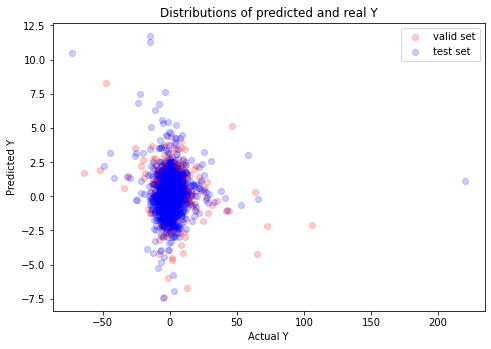

In [11]:
# Direct Linear Modling on Original Data 
model_lr = LinearRegression(copy_X=True, n_jobs=100)
model_lr.fit(X_train_window_size_15, y_train_window_size_15)

# Evaluate model performance and store it
get_cv_scores(model_lr, X_train_window_size_15, y_train_window_size_15)
mae, mse = evaluate_valid(model_lr, X_valid_window_size_15, y_valid_window_size_15, X_test_window_size_15, y_test_window_size_15)

performance_df = performance_df.append({'Model': 'Linear Regression', 
                                        'MAE score (on test set)': round(mae, 4),
                                        'MSE score (on test set)': round(mse, 4)},
                                       ignore_index=True)

CV Mean of R2:  -35.95228562453596
CV STD of R2:  64.49163346021064
Validation MAE: 5.220299393340016
Validation R2: -1.1002928290761949
Test MAE: 4.919223066456531
Test R2: -1.6395526636945683


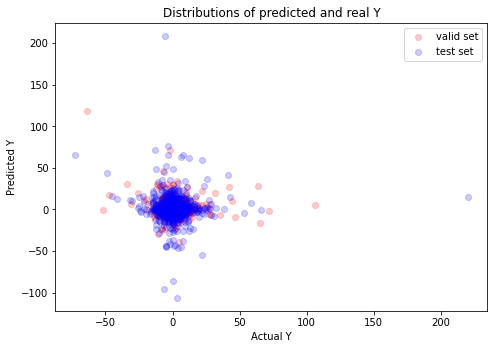

In [12]:
# Polynomial Regression (Degree=2) 
# Transformation of X_train/valid/test datasets
polynomial_features= PolynomialFeatures(degree=2)
X_train_15_poly = polynomial_features.fit_transform(X_train_window_size_15)
X_valid_15_poly = polynomial_features.fit_transform(X_valid_window_size_15)
X_test_15_poly = polynomial_features.fit_transform(X_test_window_size_15)

# Modeling
model_lr = LinearRegression(normalize=True, copy_X=True, n_jobs=100)
model_lr.fit(X_train_15_poly, y_train_window_size_15)
get_cv_scores(model_lr, X_train_15_poly, y_train_window_size_15)

# Evaluate model performance and store it
mae, mse = evaluate_valid(model_lr, X_valid_15_poly, y_valid_window_size_15, X_test_15_poly, y_test_window_size_15)
performance_df = performance_df.append({'Model': 'Linear Regression (poly transformed)', 
                                        'MAE score (on test set)': round(mae, 4),
                                        'MSE score (on test set)': round(mse, 4)},
                                       ignore_index=True)

## Random Forrest
- **Intro**:

    The Random Forest method fits on the training data using an ensemble of decision trees. An important feature of the model is that it helps avoid overfitting by building each of the tree with a sample of data points as well as a sample of the features of the original training dataset.

- **Input data**:

    > Training dataset: `X_train_window_size_15_tree` and `y_train_window_size_15`\
    > Validation dataset: `X_valid_window_size_15_tree` and `y_valid_window_size_15`\
    > Testing dataset: `X_test_window_size_15_tree` and `y_test_window_size_15`
    
    Apart from normalization, the datasets used for Random Forest modelling have also been transformed in terms of their datetime columns, such as for the variable `lasttrade_weekday`. These columns originally consisted of two sets of variables to express a certain datetime point, which has been preprocessed and converted back to their original value.

- **Architecture**:

    After comparing the models' performance on the validation dataset using GridSearchCV, the best combination of parameters for the Random Forest Regressor is:
    | Parameter name    | Value  |
    |-------------------|--------|
    | n_estimators      | 300    |
    | max_features      | 'sqrt' |
    | min_samples_split | 10     |
    | max_depth         | 8      |
    
It is worth noting that our group has also tried dropping features that are deemed the least important by the Random Forest model after performing the Grid Search, and there seemed to be little improvement in the model's performance, which is why this part has been excluded here.

In [13]:
# Modeling
rfmodel = RandomForestRegressor(random_state=3315, 
                                max_depth=8,
                                n_estimators=300,
                                max_features='sqrt',
                                min_samples_split=10,
                                criterion='mse', n_jobs=-1)
rfmodel.fit(X_train_window_size_15_tree, y_train_window_size_15)

# Evaluate model performance and store it
mae, mse = evaluate_model(rfmodel, X_test_window_size_15_tree, y_test_window_size_15)

performance_df = performance_df.append({'Model': 'Random Forest', 
                                        'MAE score (on test set)': round(mae, 4),
                                        'MSE score (on test set)': round(mse, 4)},
                                       ignore_index=True)

Mean absolut error on test: 3.038908218088867
Mean squared error on test: 43.36783762861576


- **Brief summary**:

    > As shown in the cell below, the Random Forest model's performance on the test dataset is 3.0389 in terms of MAE.
    
    ___Limitations___: 
    
    While Random Forest takes advantage of the power of ensemble, which helps avoid overfitting, it simply aggregates all the individual decision trees by training them in parallel. In other words, the trees within the Random Forest model are independent from each other and thus can't learn from each other. To address this disadvantage, we have also tried ensemble of boosted trees as shown in the following section.

## Gradient Boosting
Takeaways:

LightGBM is a gradient boosting framework using tree based approaches. Gradient boosting comes from the idea whether a weak learner can modified to become even better. Additionally, we can state that a Gradient Boosting algorithm consists of 3 elements: 1. a loss function, which needs to be optimized. 2. A weak learner to make predictions of the input data and 3. An additive model which adds weak learners to minimize the loss function. Basically, this means each new added weak learner is trained one minimizing the errors of the previous models.

In the beginning we stated the LightGBM is using tree based approaches. This also means for us that we have to conserve the sin/cos features of the time series into real integers because a tree will split its decision after one feature even though the sin/cos of the columns is one feature. 
In the previous preprocessing notebook we encoded these time series sin/cos features to use LightGBM properly. Gradient Boosting algorithms are aggressive learners which means they overfit fast. That’s why we first have to drop all features with a high correlation.

The architecture is really simple since we only need to define the right parameters. Since our group decided to optimize the model for the mean absolute error. The objective was set to regression_l1 and the metric is ‚mae‘ (mean absolute error). The parameters num_leaves and num_round are the most important parameters to tune because these regulate the over-/underfitting of our model. After several trials we identified a small number of leaves with 38 and 17 num of rounds.


Performance:

The LightGBM model is our best model and was able to achieve a slightly better mean absolute error than the DummyRegressor which was predicting the mean. By having a small number of leaves we regulated the overfitting of the model so it was able to capture more information of the training set to make better predictions on the test set.
However, gradient boosting lacks the ability to capture time series information because it is a tree approach. In our opinion we were able to minimize the main disadvantage of overfitting but we think other models can be even better by also using the time series information correctly.

### LightGBM Model

In [14]:
# Process data
train_data = lgb.Dataset(X_train_window_size_15_tree, label=y_train_window_size_15)
valid_data = lgb.Dataset(X_valid_window_size_15_tree, label=y_valid_window_size_15)
test_data = lgb.Dataset(X_test_window_size_15_tree, label=y_test_window_size_15)

# Modeling
param = {'num_leaves': 38, 'objective': 'regression_l1', 'metric': 'mae'}
num_round = 17
bst = lgb.train(param, train_data, num_round, valid_sets=[valid_data])

# Evaluate model performance and store it
mae, mse = evaluate_model(bst, X_test_window_size_15_tree, y_test_window_size_15)
performance_df = performance_df.append({'Model': 'LightGBM', 
                                        'MAE score (on test set)': round(mae, 4),
                                        'MSE score (on test set)': round(mse, 4)},
                                       ignore_index=True)

[1]	valid_0's l1: 3.47078
[2]	valid_0's l1: 3.47027
[3]	valid_0's l1: 3.46946
[4]	valid_0's l1: 3.46942
[5]	valid_0's l1: 3.46718
[6]	valid_0's l1: 3.46787
[7]	valid_0's l1: 3.46696
[8]	valid_0's l1: 3.46824
[9]	valid_0's l1: 3.46864
[10]	valid_0's l1: 3.47049
[11]	valid_0's l1: 3.46982
[12]	valid_0's l1: 3.46922
[13]	valid_0's l1: 3.47059
[14]	valid_0's l1: 3.46897
[15]	valid_0's l1: 3.46924
[16]	valid_0's l1: 3.47006
[17]	valid_0's l1: 3.47219
Mean absolut error on test: 3.0055239022394464
Mean squared error on test: 41.92262567122521


## upport Vector Regression
- **Intro**:

    The Support Vector Regression model utilizes the kernel trick to project the original dataset to a higher dimension in an efficient way. A main advantage of the model is its ability to tolerate errors within a certain range, which allows the model to become robust.

- **Input data**:

    The input data of the model has been normalized.
    
    > Training dataset: `X_train_window_size_15` and `y_train_window_size_15`\
    > Validation dataset: `X_valid_window_size_15` and `y_valid_window_size_15`\
    > Testing dataset: `X_test_window_size_15` and `y_test_window_size_15`
    
- **Architecture**:

    After comparing the models' performance on the validation dataset using GridSearchCV, the best combination of parameters for the Support Vector Regression model is:
    | Parameter name    | Value  |
    |-------------------|--------|
    | kernel      | 'poly'    |
    | C      | 25' |

In [15]:
# Modeling
svrmodel = SVR(kernel='poly', C=25)
svrmodel.fit(X_train_window_size_15, y_train_window_size_15)

# Evaluate model performance and store it
mae, mse = evaluate_model(svrmodel, X_test_window_size_15, y_test_window_size_15)
performance_df = performance_df.append({'Model': 'Support Vector Regressor', 
                                        'MAE score (on test set)': round(mae, 4),
                                        'MSE score (on test set)': round(mse, 4)},
                                       ignore_index=True)

Mean absolut error on test: 3.0078296460070626
Mean squared error on test: 41.93315890048373


- **Brief summary**:

    > As shown in the cell above, the Support Vector Regression model's performance on the test dataset is 3.008 in terms of MAE.
    
    ___Limitations___: 
    
    While Support Vector Regressor manages to introduce non-linearity by projecting the original dataset to a higher dimension space and does it in an effective way, it is relatively time consuming and requires much more resources compared to other models, especially when training on large datasets.

## KNN
The optimal k was found doing a grid search for `range(3, 25)`.  

For this 'classic' approach, the train and valid set will be put together to make use of cross-validation.

In [16]:
X_train_window_size_15_classic = X_train_window_size_15.copy().append(X_valid_window_size_15)
y_train_window_size_15_classic = y_train_window_size_15.copy().append(y_valid_window_size_15)

minmax_transformer_classic = Pipeline(steps=[('minmax', MinMaxScaler())])

preprocessor_window_size_15_classic = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('mm', minmax_transformer_classic , [X_train_window_size_15_classic.columns[1], *[*X_train_window_size_15_classic.columns[17:]]])
        ])


preprocessor_window_size_15_classic.fit(X_train_window_size_15, y_train_window_size_15)
X_train_window_size_15_classic_norm = preprocessor_window_size_15_classic.transform(X_train_window_size_15_classic)
X_test_window_size_15_classic_norm = preprocessor_window_size_15_classic.transform(X_test_window_size_15)

In [17]:
class Knn:

    def __init__(self,
                 X_train: pd.DataFrame,
                 X_test: pd.DataFrame,
                 y_train: pd.DataFrame,
                 y_test: pd.DataFrame,
                 k: int):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.k = k
        self.model = KNeighborsRegressor(n_neighbors=self.k, n_jobs=-1)
        self.mae_scorer = make_scorer(mean_absolute_error)
    
    def get_cv_scores(self):
        return cross_val_score(self.model, self.X_train, self.y_train, cv=5, scoring=self.mae_scorer)

    def fit(self):
        self.model.fit(self.X_train, self.y_train)

    def predict(self):
        predictions = self.model.predict(self.X_test)
        return predictions

    def go(self):
        cv_scores = self.get_cv_scores()
        self.fit()
        predictions = self.predict()
        return cv_scores, predictions, self.model

In [18]:
knn_15 = Knn(
    X_train_window_size_15_classic_norm,
    X_test_window_size_15_classic_norm,
    y_train_window_size_15_classic,
    y_test_window_size_15,
    k=5
)

# Fit model and get cross validation scores
knn_cv_scores_15, knn_predictions_15, knn_model_15 = knn_15.go()

CV Scores for KNN

In [19]:
knn_cv_scores_15

array([2.41780899, 2.28482631, 2.25901748, 2.55659663, 3.08557565])

In [21]:
# Evaluate model performance and store it
mae, mse = evaluate_model(knn_model_15, X_test_window_size_15_classic_norm, y_test_window_size_15)

performance_df = performance_df.append({'Model': 'K-Nearest Neighbor', 
                                        'MAE score (on test set)': round(mae, 4),
                                        'MSE score (on test set)': round(mse, 4)},
                                       ignore_index=True)

Mean absolut error on test: 3.276977688787185
Mean squared error on test: 44.11274918421052


# Creating DL models
<b>In this part, we employed multiple DL methods. </b>


## Multi-Layer Perceptron
For the MLP, the architecture seemed to be rather irrelevant. Generally speaking, simpler architectures with less neurons seemed to work as well as more complex architectures with several hidden layers and/or a large number of neurons. In total, a few hundred neurons overall were enough. Dropout, LR Scheduling and Adam optimizer created the best results.  
We also found that higher batch sizes decreased the MAE.  
One interesting finding is that the performance on the validation set would not change after 2-3 epochs. Additionally, the performance on the test set was always better than the performance on the validation set.

In [22]:
class Mlp:
    """
    Creates a multilayer-perceptron model.
    """
    def __init__(self, 
                 X_train: pd.DataFrame, 
                 X_valid: pd.DataFrame, 
                 X_test: pd.DataFrame, 
                 y_train: pd.DataFrame, 
                 y_valid: pd.DataFrame, 
                 y_test: pd.DataFrame, 
                 params: dict, 
                 layers: list, 
                 dropout: bool,
                 schedulerthresh: int,
                 optimizer,
                 earlystopping: int
                 ):
        self.X_train = X_train
        self.X_valid = X_valid
        self.X_test = X_test
        self.y_train = y_train
        self.y_valid = y_valid
        self.y_test = y_test
        self.params = params
        self.layers = layers
        self.dropout = dropout
        self.schedulerthresh = schedulerthresh
        self.optimizer = optimizer
        self.earlystopping = earlystopping
        self.model = Sequential()

    def compile_model(self):
        be.clear_session()
        self.model.add(Input(shape=(self.X_train.shape[1])))
        for i in range(len(self.layers)):
            self.model.add(Dense(self.layers[i], activation="relu"))
            if self.dropout:
                self.model.add(Dropout(rate=self.dropout))
        self.model.add(Dense(1, activation="linear"))
        optimizer = self.optimizer
        self.model.compile(loss='mean_absolute_error', optimizer=optimizer)
        return self.model
        
    def fit_model(self):
        callbacks = []
        if self.scheduler:
            callbacks.append(LearningRateScheduler(self.scheduler))
        if self.earlystopping:
            callbacks.append(EarlyStopping(monitor='loss', 
                                           patience=self.earlystopping))
        history = self.model.fit(x=self.X_train,
                                 y=self.y_train, 
                                 batch_size=self.params["BATCH_SIZE"], 
                                 validation_data=(self.X_valid,self.y_valid), 
                                 epochs=self.params["EPOCHS"], 
                                 callbacks=callbacks, 
                                 verbose=1, 
                                 shuffle=False)
        return history, self.model

    def evaluate_model(self):
        eval_score = self.model.evaluate(self.X_test, self.y_test.to_numpy())
        return eval_score, self.model

    def predict(self):
        return self.model.predict(self.X_test)
      
    def go(self):
        self.compile_model()
        history, _ = self.fit_model()
        eval_score, _ = self.evaluate_model()
        predictions = self.predict()
        return history, eval_score, predictions, self.model
        
    def scheduler(self, epoch, lr):
        if self.schedulerthresh:
            thresh = self.schedulerthresh
        else:
            thresh = 5
        if epoch < thresh:
            return lr
        else:
            return lr*exp(-0.1)


### Creating best model for MLP

In [23]:
params = {
    "BATCH_SIZE": 2048, 
    "EPOCHS": 10, 
    "LEARNING_RATE": 0.0005}
layers = [300, 100]
dropout = 0.25
scheduler = 5
optimizer = Adam(learning_rate=0.0005)
earlystopping = 3

mlp_15 = Mlp(
    X_train_window_size_15,
    X_valid_window_size_15,
    X_test_window_size_15,
    y_train_window_size_15,
    y_valid_window_size_15,
    y_test_window_size_15,
    params,
    layers,
    dropout,
    scheduler,
    optimizer,
    earlystopping
)

# Fit the model
mlp_history_15, mlp_eval_score_15, mlp_predictions_15, mlp_model_15 = mlp_15.go()

Epoch 1/10
15/15 [==============================] - 3s 31ms/step - loss: 465.5146 - val_loss: 3.6979 - lr: 5.0000e-04
Epoch 2/10
15/15 [==============================] - 0s 9ms/step - loss: 219.7682 - val_loss: 4.7449 - lr: 5.0000e-04
Epoch 3/10
15/15 [==============================] - 0s 8ms/step - loss: 89.9531 - val_loss: 3.4775 - lr: 5.0000e-04
Epoch 4/10
15/15 [==============================] - 0s 7ms/step - loss: 28.2141 - val_loss: 3.4715 - lr: 5.0000e-04
Epoch 5/10
15/15 [==============================] - 0s 8ms/step - loss: 8.1402 - val_loss: 3.4726 - lr: 5.0000e-04
Epoch 6/10
15/15 [==============================] - 0s 8ms/step - loss: 4.4272 - val_loss: 3.4729 - lr: 4.5242e-04
Epoch 7/10
15/15 [==============================] - 0s 8ms/step - loss: 3.5980 - val_loss: 3.4724 - lr: 4.0937e-04
Epoch 8/10
15/15 [==============================] - 0s 7ms/step - loss: 3.2269 - val_loss: 3.4724 - lr: 3.7041e-04
Epoch 9/10
15/15 [==============================] - 0s 8ms/step - loss: 3

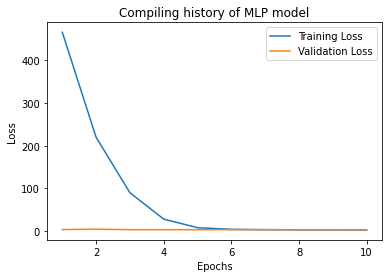

In [24]:
loss_values = mlp_history_15.history['loss']
val_loss_values = mlp_history_15.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')

plt.title("Compiling history of MLP model")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Evaluation Score of MLP

In [25]:
print(f"Mean absolut error on test: {mlp_eval_score_15}")
performance_df = performance_df.append({'Model': 'Mulit-Layer Perceptron', 
                                        'MAE score (on test set)': round(mlp_eval_score_15, 4)},
                                       ignore_index=True)

Mean absolut error on test: 3.007194995880127


## Load 3D data for Recurrent Neural Networks

In [26]:
#Write code to load the pickles
pkl_file = open("X_train_unflatten_all_15", 'rb')
X_train_unflatten_all_15 = pickle.load(pkl_file)

pkl_file = open("X_valid_unflatten_all_15", 'rb')
X_valid_unflatten_all_15 = pickle.load(pkl_file)

pkl_file = open("X_test_unflatten_all_15", 'rb')
X_test_unflatten_all_15 = pickle.load(pkl_file)

## Convolutional Neural Network
- **Intro**:

   A Convolutional Neural Network model involves multiple filters that can be used to capture complex patterns in the datasets. One of its distinct features is its parameter sharing, which can greatly increase its efficiency.

- **Input data**:

    The input data of the model has been normalized and rolled into a form of 3D data.
    
    > Training dataset: `X_train_unflatten_all_15` and `y_train_window_size_15`\
    > Validation dataset: `X_valid_unflatten_all_15` and `y_valid_window_size_15`\
    > Testing dataset: `X_test_unflatten_all_15` and `y_test_window_size_15`
    
- **Architecture**:

    When increasing the complexity of the model (whether by increasing the number of hidden layers or the number of hidden cells), its performance doesn't seem to change. With various experiments, we have arrived at a relatively simple structure that yields similar results to its more complicated alternatives: 2 pairs of Convolutional layers and Max Pooling layers, followed by 2 pairs of fully connected layers and dropout layers.

In [27]:
n_hidden_layers = 2
hidden_layer_size = 80
dropout_rate = 0.2

BATCH_SIZE = 100
EPOCHS = 20

In [28]:
tf.compat.v1.reset_default_graph()
be.clear_session()

# Define regularizer and initializer
regularizer = tf.keras.regularizers.L2(2.)
initializer = tf.keras.initializers.RandomUniform()

input_shape = np.shape(X_train_unflatten_all_15)
column_count = input_shape[2]

input_layer=Input(shape=(input_shape[1], column_count))
cur_last_layer = input_layer

for l in range(n_hidden_layers):
    cnn_layer=Conv1D(filters=5, kernel_size=4, 
                     input_shape=input_shape[1:],
                     padding='same',
                     kernel_initializer=initializer,
                     kernel_regularizer=regularizer)(cur_last_layer)
    pool = MaxPool1D(pool_size=2, strides=1)(cnn_layer)
    cur_last_layer=pool

for l in range(n_hidden_layers):
    dense = Dense(100, activation='tanh')(cur_last_layer)
    dropout_layer = Dropout(dropout_rate)(dense)
    cur_last_layer=dropout_layer

predictions=Dense(1)(cur_last_layer)

cnn_model=Model(inputs=input_layer, outputs=predictions)
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 22)]          0         
                                                                 
 conv1d (Conv1D)             (None, 14, 5)             445       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 13, 5)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 5)             105       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 12, 5)            0         
 1D)                                                             
                                                                 
 dense (Dense)               (None, 12, 100)           600   

In [29]:
optimizer = Adam(learning_rate=0.001)

cnn_model.compile(loss='mean_absolute_error', optimizer=optimizer)

cnn_history = cnn_model.fit(X_train_unflatten_all_15, y_train_window_size_15,
                            validation_data=(X_valid_unflatten_all_15, y_valid_window_size_15),
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE)

Epoch 1/20
299/299 [==============================] - 31s 9ms/step - loss: 2.3247 - val_loss: 3.4708
Epoch 2/20
299/299 [==============================] - 3s 9ms/step - loss: 2.2785 - val_loss: 3.4711
Epoch 3/20
299/299 [==============================] - 3s 8ms/step - loss: 2.2785 - val_loss: 3.4712
Epoch 4/20
299/299 [==============================] - 3s 8ms/step - loss: 2.2783 - val_loss: 3.4712
Epoch 5/20
299/299 [==============================] - 2s 8ms/step - loss: 2.2783 - val_loss: 3.4704
Epoch 6/20
299/299 [==============================] - 2s 8ms/step - loss: 2.2783 - val_loss: 3.4705
Epoch 7/20
299/299 [==============================] - 3s 8ms/step - loss: 2.2782 - val_loss: 3.4704
Epoch 8/20
299/299 [==============================] - 3s 9ms/step - loss: 2.2781 - val_loss: 3.4706
Epoch 9/20
299/299 [==============================] - 3s 9ms/step - loss: 2.2781 - val_loss: 3.4702
Epoch 10/20
299/299 [==============================] - 2s 8ms/step - loss: 2.2781 - val_loss: 3.470

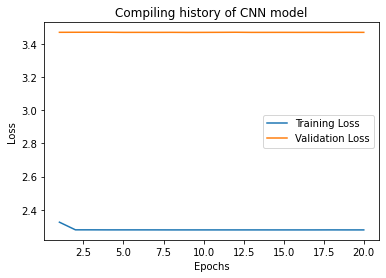

In [30]:
loss_values = cnn_history.history['loss']
val_loss_values = cnn_history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')

plt.title("Compiling history of CNN model")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [31]:
mae, mse = evaluate_3Dmodel(cnn_model, X_test_unflatten_all_15, y_test_window_size_15)

performance_df = performance_df.append({'Model': 'CNN', 
                                        'MAE score (on test set)': round(mae, 4),
                                        'MSE score (on test set)': round(mse, 4)},
                                       ignore_index=True)

Mean absolut error on test: 3.0077111388078475


- **Brief summary**:

    > As shown in the cell above, the performance of the CNN on the test dataset is 3.008 in terms of MAE.
    
    ___Limitations___: 
    
    Generally, it is more common to use CNN in image related problems, therefore, it's not surprising that the model cannot achieve high performance here. Moreover, considering the dimensionality of the data fed into the neural network (with a window size of 15 and therefore 14 "time steps"), the size of kernel that can be used is rather limited.

## Recurrent Neural Network

### LSTM: Long- Short-Term Memory

- **Intro**:

   A Long- Short-Term Memory model is a type of Recurrent Neural Network that is often used for sequence data such as in time-series and NLP problems. By introducing an additional vector, i.e., the cell state, the model is able to store important information of the past that is helpful for the prediction of the current state (or forget useless information when needed). Since the task we have involve time series data, LSTM seems to be a natural candidate for achieving high performance.

- **Input data**:

    The input data of the model has been normalized and rolled into a form of 3D data.
    
    > Training dataset: `X_train_unflatten_all_15` and `y_train_window_size_15`\
    > Validation dataset: `X_valid_unflatten_all_15` and `y_valid_window_size_15`\
    > Testing dataset: `X_test_unflatten_all_15` and `y_test_window_size_15`
    
- **Architecture**:

    When increasing the complexity of the model (whether by increasing the number of hidden layers or the number of hidden cells), its performance doesn't seem to change. Below is one of the structures that yields similar results to its alternatives, with 3 pairs of LSTM layers and dropout layers followed by 3 pairs of fully connected layers and dropout layers.

In [32]:
n_hidden_layers = 3
hidden_layer_size = 400
dropout_rate = 0.3

BATCH_SIZE = 500
EPOCHS = 25

In [33]:
tf.compat.v1.reset_default_graph()
be.clear_session()

input_shape[2]
column_count = np.shape(X_train_unflatten_all_15)[2]

input_layer=Input(shape=(np.shape(X_train_unflatten_all_15)[1], column_count))
cur_last_layer=input_layer

for l in range(n_hidden_layers):
    hidden_layer=LSTM(hidden_layer_size, return_sequences=True)(cur_last_layer)
    dropout_layer = Dropout(0.5)(hidden_layer)
    cur_last_layer=dropout_layer

for l in range(n_hidden_layers):
    dense = Dense(120, activation='tanh')(cur_last_layer)
    dropout_layer = Dropout(dropout_rate)(dense)
    cur_last_layer=dropout_layer

predictions=Dense(1)(cur_last_layer)

lstm_model=Model(inputs=input_layer, outputs=predictions)
lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 22)]          0         
                                                                 
 lstm (LSTM)                 (None, 14, 400)           676800    
                                                                 
 dropout (Dropout)           (None, 14, 400)           0         
                                                                 
 lstm_1 (LSTM)               (None, 14, 400)           1281600   
                                                                 
 dropout_1 (Dropout)         (None, 14, 400)           0         
                                                                 
 lstm_2 (LSTM)               (None, 14, 400)           1281600   
                                                                 
 dropout_2 (Dropout)         (None, 14, 400)           0     

In [34]:
optimizer = RMSprop(learning_rate=0.0025)
lstm_model.compile(loss='mean_absolute_error', optimizer=optimizer)

lstm_history = lstm_model.fit(X_train_unflatten_all_15, y_train_window_size_15,
                              validation_data=(X_valid_unflatten_all_15, y_valid_window_size_15),
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE)

Epoch 1/25
60/60 [==============================] - 17s 155ms/step - loss: 2.4346 - val_loss: 3.4837
Epoch 2/25
60/60 [==============================] - 8s 128ms/step - loss: 2.3171 - val_loss: 3.4939
Epoch 3/25
60/60 [==============================] - 8s 128ms/step - loss: 2.2869 - val_loss: 3.4730
Epoch 4/25
60/60 [==============================] - 8s 128ms/step - loss: 2.2788 - val_loss: 3.4701
Epoch 5/25
60/60 [==============================] - 8s 127ms/step - loss: 2.2786 - val_loss: 3.4704
Epoch 6/25
60/60 [==============================] - 8s 130ms/step - loss: 2.2785 - val_loss: 3.4710
Epoch 7/25
60/60 [==============================] - 8s 128ms/step - loss: 2.2790 - val_loss: 3.4704
Epoch 8/25
60/60 [==============================] - 8s 127ms/step - loss: 2.2782 - val_loss: 3.4705
Epoch 9/25
60/60 [==============================] - 8s 127ms/step - loss: 2.2782 - val_loss: 3.4690
Epoch 10/25
60/60 [==============================] - 8s 127ms/step - loss: 2.2782 - val_loss: 3.470

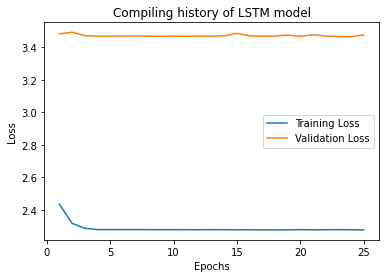

In [35]:
loss_values = lstm_history.history['loss']
val_loss_values = lstm_history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')

plt.title("Compiling history of LSTM model")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [36]:
mae, mse = evaluate_3Dmodel(lstm_model, X_test_unflatten_all_15, y_test_window_size_15)

performance_df = performance_df.append({'Model': 'LSTM', 
                                        'MAE score (on test set)': round(mae, 4),
                                        'MSE score (on test set)': round(mse, 4)},
                                       ignore_index=True)

Mean absolut error on test: 3.013370053904862


- **Brief summary**:

    > As shown in the cell above, the LSTM model's performance on the test dataset is 3.012 in terms of MAE.
    
    ___Limitations___: 
    
    While the structure of LSTM, especially the introduction of the cell state, allows it to process sequence data better, again, as mentioned above, due to the limitation caused by dimensionality of the input data (with a window size of 15 and therefore 14 "time steps"), the maximum context information that the neural network can store in the cell state is restricted, which is possibly the reason why the network fails to learn much additional information and predict better compared to other models shown above.

### Gated Recurrent Unit

- **Intro**:

   A Gated Recurrent Unit model is another type of Recurrent Neural Network. Compared to LSTM, a GRU neural network has fewer gates and parameters and therefore is more efficient to train.

- **Input data**:

    The input data of the model has been normalized and rolled into a form of 3D data.
    
    > Training dataset: `X_train_unflatten_all_15` and `y_train_window_size_15`\
    > Validation dataset: `X_valid_unflatten_all_15` and `y_valid_window_size_15`\
    > Testing dataset: `X_test_unflatten_all_15` and `y_test_window_size_15`
    
- **Architecture**:

    When increasing the complexity of the model (either by increasing the number of hidden layers or the number of hidden cells), its performance doesn't seem to change. Below is one of the structures that yields similar results to its alternatives, with 2 GRU layers followed by 2 pairs of fully connected layers and dropout layers.

In [37]:
n_hidden_layers = 2
hidden_layer_size = 300
dropout_rate = 0.5

BATCH_SIZE = 300
EPOCHS = 20

In [38]:
tf.compat.v1.reset_default_graph()
be.clear_session()

column_count = np.shape(X_train_unflatten_all_15)[2]

input_layer=Input(shape=(np.shape(X_train_unflatten_all_15)[1], column_count))
cur_last_layer=input_layer

for l in range(n_hidden_layers):
    hidden_layer=GRU(hidden_layer_size, return_sequences=True)(cur_last_layer)
    cur_last_layer=hidden_layer

for l in range(n_hidden_layers):
    dense = Dense(120, activation='sigmoid')(cur_last_layer)
    dropout_layer = Dropout(dropout_rate)(dense)
    cur_last_layer=dropout_layer
predictions=Dense(1)(cur_last_layer)

gru_model=Model(inputs=input_layer, outputs=predictions)
gru_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 22)]          0         
                                                                 
 gru (GRU)                   (None, 14, 300)           291600    
                                                                 
 gru_1 (GRU)                 (None, 14, 300)           541800    
                                                                 
 dense (Dense)               (None, 14, 120)           36120     
                                                                 
 dropout (Dropout)           (None, 14, 120)           0         
                                                                 
 dense_1 (Dense)             (None, 14, 120)           14520     
                                                                 
 dropout_1 (Dropout)         (None, 14, 120)           0     

In [39]:
#For shape remeber, we have a variable defining the "window" and the features in the window...
optimizer = RMSprop(learning_rate=0.0015)
gru_model.compile(loss='mean_absolute_error', optimizer=optimizer)

gru_history = gru_model.fit(X_train_unflatten_all_15, y_train_window_size_15,
                              validation_data=(X_valid_unflatten_all_15, y_valid_window_size_15),
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE)

Epoch 1/20
100/100 [==============================] - 9s 48ms/step - loss: 2.3324 - val_loss: 3.4697
Epoch 2/20
100/100 [==============================] - 4s 36ms/step - loss: 2.2829 - val_loss: 3.4710
Epoch 3/20
100/100 [==============================] - 4s 36ms/step - loss: 2.2792 - val_loss: 3.4721
Epoch 4/20
100/100 [==============================] - 4s 36ms/step - loss: 2.2784 - val_loss: 3.4700
Epoch 5/20
100/100 [==============================] - 4s 35ms/step - loss: 2.2782 - val_loss: 3.4711
Epoch 6/20
100/100 [==============================] - 4s 36ms/step - loss: 2.2781 - val_loss: 3.4706
Epoch 7/20
100/100 [==============================] - 4s 36ms/step - loss: 2.2781 - val_loss: 3.4703
Epoch 8/20
100/100 [==============================] - 4s 36ms/step - loss: 2.2781 - val_loss: 3.4703
Epoch 9/20
100/100 [==============================] - 4s 35ms/step - loss: 2.2781 - val_loss: 3.4702
Epoch 10/20
100/100 [==============================] - 4s 36ms/step - loss: 2.2781 - val_lo

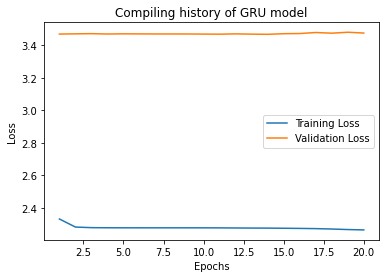

In [40]:
loss_values = gru_history.history['loss']
val_loss_values = gru_history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')

plt.title('Compiling history of GRU model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [41]:
mae, mse = evaluate_3Dmodel(gru_model, X_test_unflatten_all_15, y_test_window_size_15)

performance_df = performance_df.append({'Model': 'GRU', 
                                        'MAE score (on test set)': round(mae, 4),
                                        'MSE score (on test set)': round(mse, 4)},
                                       ignore_index=True)

Mean absolut error on test: 3.004458470752285


- **Brief summary**:

    > As shown in the cell above, the GRU model's performance on the test dataset is 3.018 in terms of MAE.
    
    Compared to LSTM, GRU yields a slightly worse performance on the test set. Moreover, the graphs of the compile histories of both models seem very similar--both show that there is little learning after the first 2 or 3 epochs.
    
    ___Limitations___: 
    
    With fewer parameters and gates in the neural network, while the speed of training has been increased, the complexity that can be captured by GRU is also reduced, which could be the reason for its lower performance results.

## Transformers: Attention is all you need!

### Self-Attention

- **Intro**:

The Attention mechanism is one of the state of the art architecture. To gain some experience with it our group decided to try the attention architecture on the our electricity data.
However, our prediction problem is not a sequence thats why we have to apply the self-attention mechanism. In the self-attention mechanism both the source of the queries and the target of the attention are input embeddings and are learned projections.

During training we identified that high drop_out rate of 0.5 helps a lot to have a good convergence. Additionally, a batch size of 64 and and a dense layer size of 256 which enables the model to learn well.

Unluckily, the model was also not able to beat the Dummy Regressor but for our group we learned very well how to apply self attention to predict.

   

- **Input data**:

    The input data of the model has been normalized and rolled into a form of 3D data.
    
    > Training dataset: `X_train_window_size_15` and `y_train_window_size_15`\
    > Validation dataset: `X_valid_window_size_15` and `y_valid_window_size_15`\
    > Testing dataset: `X_test_window_size_15` and `y_test_window_size_15`

 
- **Architecture**:

1. Input Layer
2. Embedding Layer for the query
3. Self-Attention layer with the inputs and embedding layer
4. Concatenating the input and attention layer
5. 2x Dense Layers followed by a Dropout Layer
6. Output Layer with a linear activation function


In [42]:
EPOCHS = 50
BATCH_SIZE = 64
DENSE_LAYER_SIZE = 256
DROP_OUT = 0.0

In [47]:
tf.compat.v1.reset_default_graph()
be.clear_session()

def create_self_attention():

    
    inputs_q = Input(shape=(X_train_window_size_15.shape[1],))

    dense_embedding_layer_q = Dense(X_train_window_size_15.shape[1], activation='softmax')(inputs_q)

    self_attention = tf.keras.layers.Attention()([inputs_q, dense_embedding_layer_q])

    attention_inputs = merge.Concatenate()([inputs_q, self_attention])

    Dense1 = Dense(DENSE_LAYER_SIZE, name='Dense1', activation='relu')(attention_inputs)

    Dropout1 = Dropout(DROP_OUT)(Dense1)

    Dense2 = Dense(DENSE_LAYER_SIZE, name='Dense2', activation='relu')(Dropout1)
    Dropout2 = Dropout(DROP_OUT)(Dense2)

    output = Dense(1, name='output', activation='linear')(Dropout2)

    model = Model(inputs=[inputs_q], outputs=output)
    print("Architecture of model:\n")
    model.summary()

    #Since we are using a 'state of the art'-model we also tried the 'state of the art'-optimizer "ranger"
    radam = tfa.optimizers.RectifiedAdam()
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    
    model.compile(optimizer=ranger, loss='mae')

    model_history = model.fit(X_train_window_size_15, y_train_window_size_15, 
                              validation_data=(X_valid_window_size_15, y_valid_window_size_15), 
                              epochs=EPOCHS, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False)

    return model, model_history

In [48]:
model, model_history = create_self_attention()

Architecture of model:

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 102)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 102)          10506       ['input_1[0][0]']                
                                                                                                  
 attention (Attention)          (None, 102)          0           ['input_1[0][0]',                
                                                                  'dense[0][0]']                  
                                                                                                  
 concatenate (Concatenate)      (None, 204)          0           ['inp

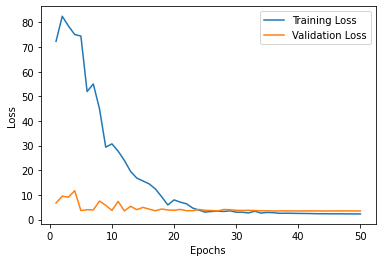

In [49]:
loss_values = model_history.history['loss']
val_loss_values = model_history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [51]:
mae, mse = evaluate_model(model, X_test_window_size_15, y_test_window_size_15)

performance_df = performance_df.append({'Model': 'GRU', 
                                        'MAE score (on test set)': round(mae, 4),
                                        'MSE score (on test set)': round(mse, 4)},
                                       ignore_index=True)

Mean absolut error on test: 3.008265976374479
Mean squared error on test: 41.88905556137337


# Summary
<b>In this part, we summairzed the results of all the models above. </b>


In [52]:
performance_df.sort_values('MAE score (on test set)')

,Model,MAE score (on test set),MSE score (on test set)
10,GRU,3.0045,41.9208
4,LightGBM,3.0055,41.9226
7,Mulit-Layer Perceptron,3.0072,NaN
8,CNN,3.0077,41.9333
5,Support Vector Regressor,3.0078,41.9332
11,GRU,3.0083,41.8891
0,Dummy Regressor,3.0112,41.9299
9,LSTM,3.0134,42.0221
3,Random Forest,3.0389,43.3678
1,Linear Regression,3.1070,43.5284


**Observations**: 
Since the results for data with a window size of 15 are similar to that with a window size of 5, to avoid repetition, please refer to the jupyter notebook/presentation slides for our analysis.